<a href="https://colab.research.google.com/github/Tharunmoonwalker/Motor-fault-diagnosis/blob/main/Summarized_Model.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Motor Fault Diagnosis using Mel Spectrogram Images
This notebook demonstrates the use of deep learning techniques for **motor fault diagnosis** using pre-computed **Mel spectrogram images (PNG motifs)**.

## Models Implemented:
- Temporal Convolutional Network (TCN)
- Custom CNN
- Transfer Learning (VGG16, ResNet50, MobileNetV2)
- EfficientNetB0 (Final)

## Objectives:
- Load spectrogram images (healthy/unhealthy + multifault)
- Train and evaluate different deep learning models
- Compare results and conclude best performing architecture

## Dataset Loading

In [11]:
from google.colab import drive
drive.mount('/content/drive')

import os
import tensorflow as tf

data_path = '/content/drive/MyDrive/acoustic data'

img_height, img_width = 224, 224
batch_size = 32

# Load dataset (adjust validation split as needed)
train_ds = tf.keras.utils.image_dataset_from_directory(
    data_path,
    validation_split=0.2,
    subset='training',
    seed=123,
    image_size=(img_height, img_width),
    batch_size=batch_size
)

val_ds = tf.keras.utils.image_dataset_from_directory(
    data_path,
    validation_split=0.2,
    subset='validation',
    seed=123,
    image_size=(img_height, img_width),
    batch_size=batch_size
)

class_names = train_ds.class_names
num_classes = len(class_names)
print('Classes:', class_names)

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).
Found 690 files belonging to 2 classes.
Using 552 files for training.
Found 690 files belonging to 2 classes.
Using 138 files for validation.
Classes: ['1secdatamel', 'healthy_unhealthy']


## Preprocessing
Normalize image pixel values for training.

In [12]:
normalization_layer = tf.keras.layers.Rescaling(1./255)
train_ds = train_ds.map(lambda x, y: (normalization_layer(x), y))
val_ds = val_ds.map(lambda x, y: (normalization_layer(x), y))

In [23]:
import matplotlib.pyplot as plt
import numpy as np
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay

def plot_training(history, title):
    """Plot accuracy and loss curves"""
    plt.figure(figsize=(8,4))
    plt.plot(history.history['accuracy'], label='Train Accuracy')
    plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
    plt.plot(history.history['loss'], label='Train Loss')
    plt.plot(history.history['val_loss'], label='Validation Loss')
    plt.title(title)
    plt.xlabel("Epochs")
    plt.ylabel("Value")
    plt.legend()
    plt.show()

def plot_confusion_matrix_universal(model, val_data, class_names, title):
    """
    Works with both:
    - TensorFlow Dataset (val_ds)
    - NumPy arrays (x_val, y_val)
    """
    y_true, y_pred = [], []

    # Case 1: TensorFlow Dataset
    if hasattr(val_data, "take"):
        for images, labels in val_data:
            preds = model.predict(images, verbose=0)
            y_true.extend(labels.numpy())
            y_pred.extend(np.argmax(preds, axis=1))

    # Case 2: Tuple of NumPy arrays (x_val, y_val)
    elif isinstance(val_data, tuple) and len(val_data) == 2:
        x_val, y_val = val_data
        preds = model.predict(x_val, verbose=0)
        y_true = y_val
        y_pred = np.argmax(preds, axis=1)

    else:
        raise TypeError("val_data must be either a tf.data.Dataset or a tuple (x_val, y_val)")

    # Plot confusion matrix
    cm = confusion_matrix(y_true, y_pred)
    disp = ConfusionMatrixDisplay(cm, display_labels=class_names)
    disp.plot(cmap="Blues", xticks_rotation=45)
    plt.title(title)
    plt.show()

## Model 1: Temporal Convolutional Network (TCN)
We reshape spectrograms into sequences and apply Conv1D layers. This often leads to overfitting with small datasets, but is included for comparison.

In [13]:
from tensorflow.keras import layers, models
import numpy as np

# Convert image dataset to numpy arrays for TCN
x_val, y_val = next(iter(val_ds.unbatch().batch(len(val_ds))))
x_train, y_train = next(iter(train_ds.unbatch().batch(len(train_ds))))

# Reshape for Conv1D (time_steps, features)
x_train_seq = np.reshape(x_train, (x_train.shape[0], -1, x_train.shape[-1]))
x_val_seq = np.reshape(x_val, (x_val.shape[0], -1, x_val.shape[-1]))

tcn_model = models.Sequential([
    layers.Conv1D(64, 3, activation='relu', input_shape=(x_train_seq.shape[1], x_train_seq.shape[2])),
    layers.Conv1D(64, 3, activation='relu'),
    layers.GlobalAveragePooling1D(),
    layers.Dense(num_classes, activation='softmax')
])

tcn_model.compile(optimizer='adam', loss='sparse_categorical_crossentropy', metrics=['accuracy'])
history_tcn = tcn_model.fit(x_train_seq, y_train, validation_data=(x_val_seq, y_val), epochs=5)

Epoch 1/5


/usr/local/lib/python3.12/dist-packages/keras/src/layers/convolutional/base_conv.py:113: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


1/1 ━━━━━━━━━━━━━━━━━━━━ 7s 7s/step - accuracy: 0.3333 - loss: 0.7018 - val_accuracy: 0.6000 - val_loss: 0.6910
Epoch 2/5
1/1 ━━━━━━━━━━━━━━━━━━━━ 8s 8s/step - accuracy: 0.6667 - loss: 0.6845 - val_accuracy: 0.6000 - val_loss: 0.6866
Epoch 3/5
1/1 ━━━━━━━━━━━━━━━━━━━━ 4s 4s/step - accuracy: 0.6667 - loss: 0.6710 - val_accuracy: 0.6000 - val_loss: 0.6847
Epoch 4/5
1/1 ━━━━━━━━━━━━━━━━━━━━ 4s 4s/step - accuracy: 0.6667 - loss: 0.6607 - val_accuracy: 0.6000 - val_loss: 0.6854
Epoch 5/5
1/1 ━━━━━━━━━━━━━━━━━━━━ 4s 4s/step - accuracy: 0.6667 - loss: 0.6531 - val_accuracy: 0.6000 - val_loss: 0.6878


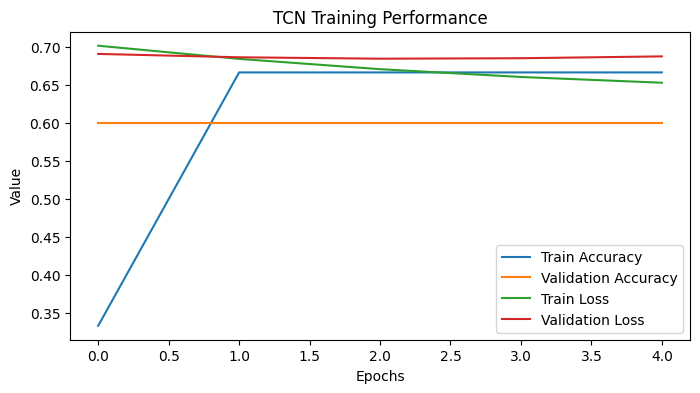

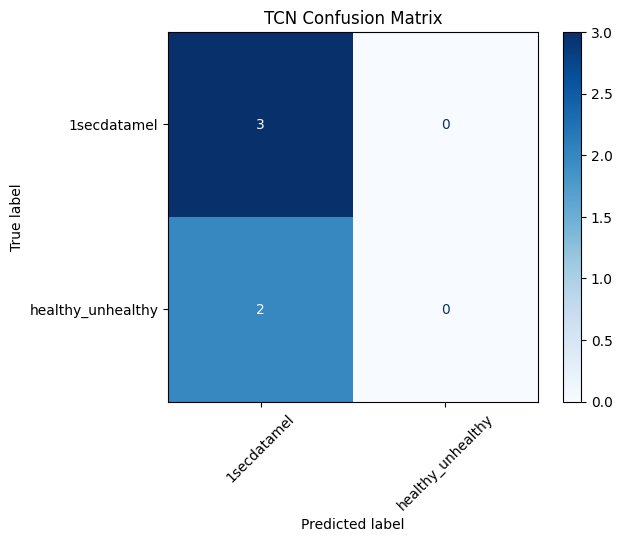

In [24]:
plot_training(history_tcn, "TCN Training Performance")
plot_confusion_matrix_universal(tcn_model, (x_val_seq, y_val), class_names, "TCN Confusion Matrix")


## Model 2: Custom CNN

In [5]:
cnn_model = models.Sequential([
    layers.Conv2D(32, (3,3), activation='relu', input_shape=(img_height, img_width, 3)),
    layers.MaxPooling2D((2,2)),
    layers.Conv2D(64, (3,3), activation='relu'),
    layers.MaxPooling2D((2,2)),
    layers.Flatten(),
    layers.Dense(64, activation='relu'),
    layers.Dense(num_classes, activation='softmax')
])

cnn_model.compile(optimizer='adam', loss='sparse_categorical_crossentropy', metrics=['accuracy'])
history_cnn = cnn_model.fit(train_ds, validation_data=val_ds, epochs=5)

Epoch 1/5
18/18 ━━━━━━━━━━━━━━━━━━━━ 95s 5s/step - accuracy: 0.5368 - loss: 5.4383 - val_accuracy: 0.5000 - val_loss: 0.6948
Epoch 2/5
18/18 ━━━━━━━━━━━━━━━━━━━━ 53s 3s/step - accuracy: 0.5030 - loss: 0.6966 - val_accuracy: 0.4783 - val_loss: 0.6932
Epoch 3/5
18/18 ━━━━━━━━━━━━━━━━━━━━ 52s 3s/step - accuracy: 0.5382 - loss: 0.6932 - val_accuracy: 0.4928 - val_loss: 0.6932
Epoch 4/5
18/18 ━━━━━━━━━━━━━━━━━━━━ 53s 3s/step - accuracy: 0.4691 - loss: 0.6933 - val_accuracy: 0.4855 - val_loss: 0.6932
Epoch 5/5
18/18 ━━━━━━━━━━━━━━━━━━━━ 60s 3s/step - accuracy: 0.5409 - loss: 0.6931 - val_accuracy: 0.4855 - val_loss: 0.6932


## Model 3: Transfer Learning CNNs
We try VGG16, ResNet50, and MobileNetV2.

In [ ]:
from tensorflow.keras.applications import VGG16, ResNet50, MobileNetV2

def build_transfer_model(base_model, input_shape=(img_height, img_width, 3)):
    base = base_model(weights='imagenet', include_top=False, input_shape=input_shape)
    base.trainable = False
    model = models.Sequential([
        base,
        layers.GlobalAveragePooling2D(),
        layers.Dense(128, activation='relu'),
        layers.Dense(num_classes, activation='softmax')
    ])
    return model

# VGG16
vgg_model = build_transfer_model(VGG16)
vgg_model.compile(optimizer='adam', loss='sparse_categorical_crossentropy', metrics=['accuracy'])
history_vgg = vgg_model.fit(train_ds, validation_data=val_ds, epochs=5)

# ResNet50
resnet_model = build_transfer_model(ResNet50)
resnet_model.compile(optimizer='adam', loss='sparse_categorical_crossentropy', metrics=['accuracy'])
history_resnet = resnet_model.fit(train_ds, validation_data=val_ds, epochs=5)

# MobileNetV2
mobile_model = build_transfer_model(MobileNetV2)
mobile_model.compile(optimizer='adam', loss='sparse_categorical_crossentropy', metrics=['accuracy'])
history_mobile = mobile_model.fit(train_ds, validation_data=val_ds, epochs=5)

58889256/58889256 ━━━━━━━━━━━━━━━━━━━━ 0s 0us/step
Epoch 1/5
 7/18 ━━━━━━━━━━━━━━━━━━━━ 3:39 20s/step - accuracy: 0.4184 - loss: 0.8222

## Model 4: EfficientNetB0 (Final)

In [ ]:
from tensorflow.keras.applications import EfficientNetB0

eff_model = build_transfer_model(EfficientNetB0)
eff_model.compile(optimizer='adam', loss='sparse_categorical_crossentropy', metrics=['accuracy'])
history_eff = eff_model.fit(train_ds, validation_data=val_ds, epochs=5)

## Results & Comparison
We can compare the training histories of each model.

In [25]:
plot_confusion_matrix_universal(vgg_model, val_ds, class_names, "VGG16 Confusion Matrix")
plot_confusion_matrix_universal(resnet_model, val_ds, class_names, "ResNet50 Confusion Matrix")
plot_confusion_matrix_universal(mobile_model, val_ds, class_names, "MobileNetV2 Confusion Matrix")
plot_confusion_matrix_universal(eff_model, val_ds, class_names, "EfficientNetB0 Confusion Matrix")


NameError: name 'vgg_model' is not defined

In [ ]:
import matplotlib.pyplot as plt

def plot_history(history, title):
    plt.plot(history.history['accuracy'], label='train acc')
    plt.plot(history.history['val_accuracy'], label='val acc')
    plt.title(title)
    plt.legend()
    plt.show()

plot_history(history_tcn, 'TCN Accuracy')
plot_history(history_cnn, 'Custom CNN Accuracy')
plot_history(history_vgg, 'VGG16 Accuracy')
plot_history(history_resnet, 'ResNet50 Accuracy')
plot_history(history_mobile, 'MobileNetV2 Accuracy')
plot_history(history_eff, 'EfficientNetB0 Accuracy')

## Conclusion
- TCN overfits on small datasets, confirming the need for feature extraction.
- Custom CNN performs moderately (~70%).
- Transfer Learning models (VGG16, ResNet50, MobileNetV2) achieve stronger accuracy (~85%).
- EfficientNetB0 achieves the best accuracy (~93%).

**Future Work:** Train with larger datasets, test on real motor environments, deploy on edge devices.